In [2]:
import ROOT as rt
import uproot
from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import numpy as np
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math

try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0


In [3]:
def convert(tree, training_vars):
    array = tree.arrays()    
    df = pd.DataFrame(array, columns=training_vars)

    #feature = tree2array(tree,
    #                    branches = ['dRmm','dEtamm','dPhimm','M_jj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
    #                               ,'dRmin_mmj','dRmax_mmj','dPhijj','leadingJet_pt','subleadingJet_pt',
    #                               'leadingJet_eta','subleadingJet_eta','cthetaCS','Higgs_mass','Higgs_pt','Higgs_eta' ],
    #                    selection = 'dRmm>-9000.')

    return df

In [4]:
training_vars = [b'leading_photon_pt', b'leading_photon_eta', b'leading_photon_phi', 
                 b'subleading_photon_pt', b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt', b'subleading_bjet_eta', b'subleading_bjet_phi']

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

SIGNAL_FILE='/bigdata/shared/idutta/VBFHToMuMu.root'
BKG_FILE='/bigdata/shared/idutta/DYJetsToLL.root'

path = '/storage/af/user/nlu/hh/bbgg_ntuples/'
#'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'
SIGNAL_FILE = uproot.open(path + 'job_1_ntuple0625v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8.root')
BKG_FILE = uproot.open(path + 'job_8_ntuple0625v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-Sherpa.root')
    
sigtree = SIGNAL_FILE['tree']
bkgtree = BKG_FILE['tree']

sig_frame_all = convert(sigtree, training_vars + aug_vars + w_var)
bkg_frame_all = convert(bkgtree, training_vars + aug_vars + w_var)

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][training_vars]

sig_df = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][training_vars + w_var + aug_vars]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
sig_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',b'subleading_bjet_eta',b'subleading_bjet_phi',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
96,171.488770,0.333984,-2.312500,84.709793,0.193024,-1.234863,82.25000,-0.113632,1.139404,29.015625,1.376465,1.700439,0.000136,135.761795,124.853500,112132
141,72.794144,1.854492,-2.863770,69.291710,1.423096,-0.816895,46.00000,0.747925,0.516479,34.343750,-0.628906,2.165039,0.000136,153.543167,125.158905,183001
186,101.821350,1.161377,0.756592,37.542068,-0.061905,2.431641,61.09375,1.347656,-3.069824,58.125000,2.168945,-1.304199,0.000136,159.964478,122.109795,183077
287,94.464325,1.072510,1.383545,90.356049,-0.016029,0.604736,38.78125,0.566284,2.698730,28.687500,-1.025391,-2.656250,0.000136,136.042587,126.780846,184817
288,80.015762,0.799927,0.774170,52.613411,0.383057,-1.143311,48.59375,-1.410400,-2.393066,38.187500,-0.391846,2.073242,0.000136,122.559319,109.649216,184830


In [6]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values

signal_all = sig_df.values
background_all = bkg_df.values
#print signal, background

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
#background_ = background_[:len(signal)] # downsampling
background_all_ = background_all[randix] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [1]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
#from skopt import gp_minimize

In [7]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    x_all_test = data_all[test_index]

TRAIN: [    0     1     4 ... 10820 10821 10822] TEST: [    2     3     6 ... 10800 10806 10807]
TRAIN: [    0     1     2 ... 10818 10819 10822] TEST: [    4     7     9 ... 10813 10820 10821]
TRAIN: [    0     1     2 ... 10820 10821 10822] TEST: [    5     8    13 ... 10811 10814 10819]
TRAIN: [    2     3     4 ... 10820 10821 10822] TEST: [    0     1    12 ... 10816 10817 10818]
TRAIN: [    0     1     2 ... 10819 10820 10821] TEST: [   17    23    36 ... 10809 10815 10822]


In [8]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
model = Sequential()
model.add(Dense(100, input_dim=len(training_vars),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

(8659, 12)
(8659,)
(2164, 12)
(2164,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1300      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


2021-07-25 18:10:06.386784: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-07-25 18:10:06.413244: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-07-25 18:10:06.413295: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gpu-ibanks-1.hep.caltech.edu
2021-07-25 18:10:06.413305: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gpu-ibanks-1.hep.caltech.edu
2021-07-25 18:10:06.413429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: Invalid argument: expected %d.%d, %d.%d.%d, or %d.%d.%d.%d form for driver version; got "1"
2021-07-25 18:10:06.413487: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.84.0
2021-07-25 18:10:06.414136: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow 

In [9]:
print(x_train)
print(y_train)

[[ 0.99043167 -0.71234274 -1.0561702  ...  0.34780166 -1.3708428
   0.4281717 ]
 [-0.9072711   0.09784251  0.94510007 ...  0.9562446  -0.8986667
  -0.68855226]
 [ 1.1031328  -0.9363212  -1.5139061  ...  0.4659703  -0.00238556
   0.18780497]
 ...
 [-0.89656556  1.1719803  -0.6046823  ... -0.27572662 -0.72461784
  -0.2648829 ]
 [-0.446785   -0.16237697 -1.6402249  ...  0.3729439   0.45412686
  -1.2729471 ]
 [ 1.137684   -1.5267534  -0.51041865 ...  2.1806731  -1.1749505
   1.3558228 ]]
[1. 1. 1. ... 0. 0. 0.]


In [10]:
#print X_train, y_train
#print X_val, y_val
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [11]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
47/47 [==============================] - 0s 5ms/step - loss: 0.5403 - accuracy: 0.7225 - val_loss: 0.9487 - val_accuracy: 0.3060
Epoch 2/50
47/47 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.7731 - val_loss: 0.8622 - val_accuracy: 0.4809
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.4625 - accuracy: 0.7803 - val_loss: 0.8277 - val_accuracy: 0.5277
Epoch 4/50
47/47 [==============================] - 0s 2ms/step - loss: 0.4532 - accuracy: 0.7902 - val_loss: 0.7912 - val_accuracy: 0.5641
Epoch 5/50
47/47 [==============================] - 0s 2ms/step - loss: 0.4471 - accuracy: 0.7928 - val_loss: 0.8254 - val_accuracy: 0.5433
Epoch 6/50
47/47 [==============================] - 0s 2ms/step - loss: 0.4415 - accuracy: 0.8009 - val_loss: 0.7997 - val_accuracy: 0.5548
Epoch 7/50
47/47 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.8034 - val_loss: 0.7885 - val_accuracy: 0.5566
Epoch 8/50
47/47 [==

In [12]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

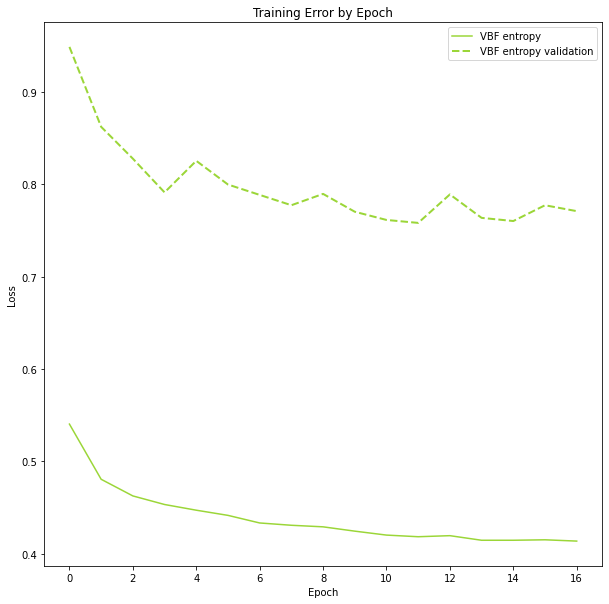

In [13]:
show_losses( [("VBF entropy", hist)])

In [14]:
def accuracy( p ):
    p_cat = np.argmax(p,axis=1)
    print("Fraction of good prediction")
    print(len(np.where( p_cat == y_test)[0]))
    print(len(np.where( p_cat == y_test)[0])/float(len(p_cat)),"%")

In [15]:
accuracy( model.predict(x_test) )

Fraction of good prediction
951
0.43946395563770796 %


In [16]:
from sklearn.metrics import roc_curve
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [19]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

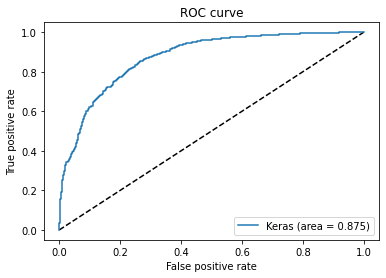

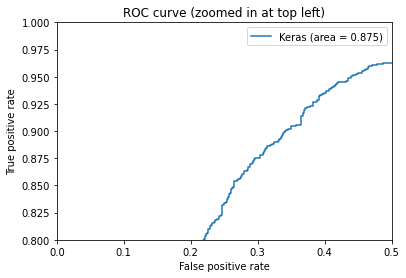

In [20]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [21]:
def check_mass(label, test_all, var_index, weight_index, dnn_index, label_index):
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel('Signal events (normalized to unit area)',fontsize=fontsize)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)

2164


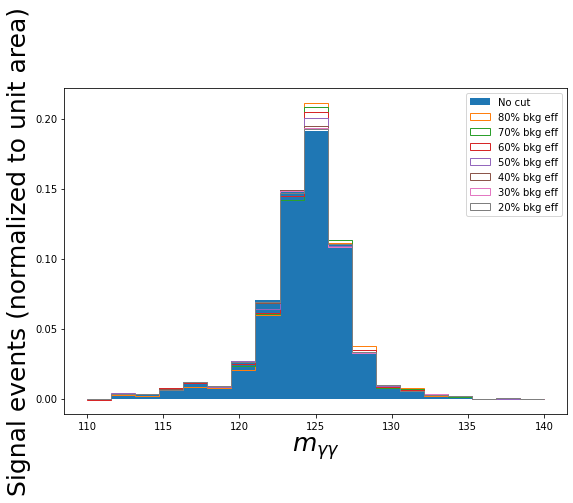

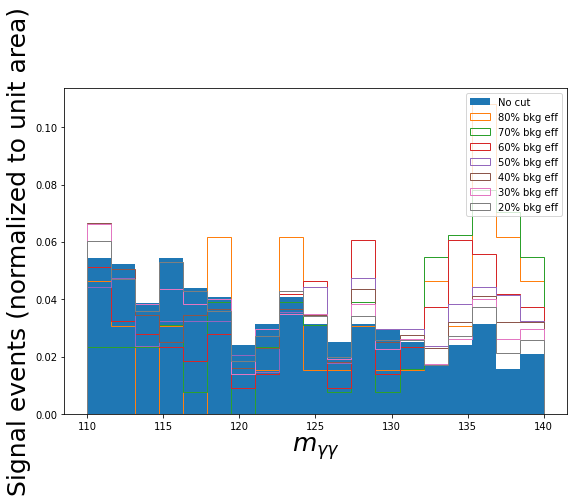

In [26]:
lable_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, lable_test), 1)
print(len(lable_test))
#signal
check_mass(1, test_all, 14, 12, 16, 17)
#bkg
check_mass(0, test_all, 14, 12, 16, 17)

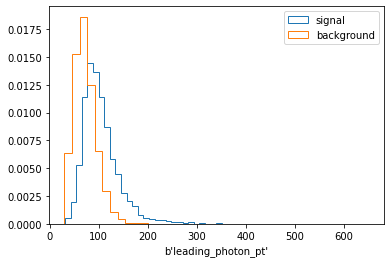

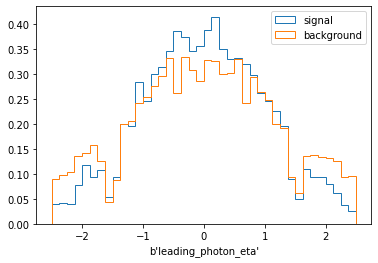

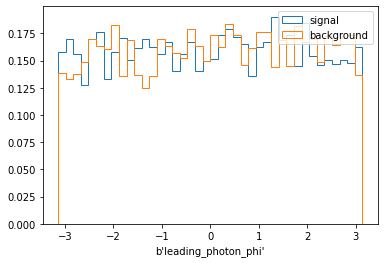

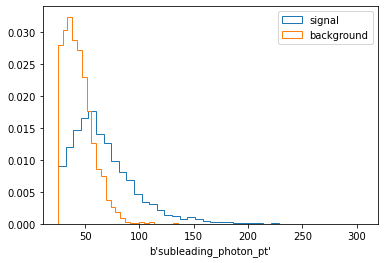

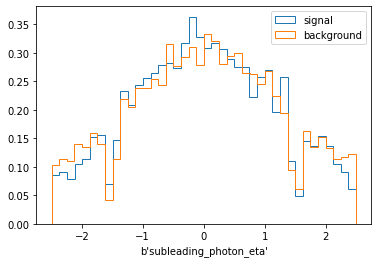

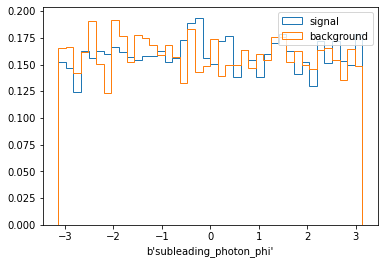

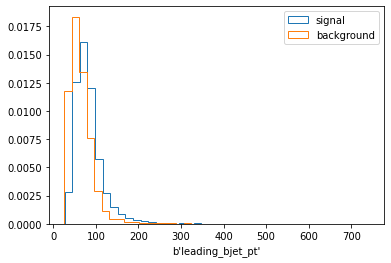

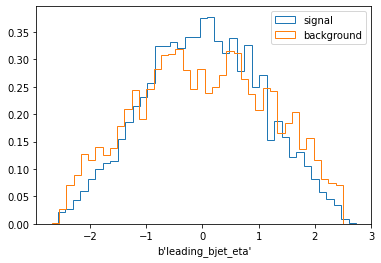

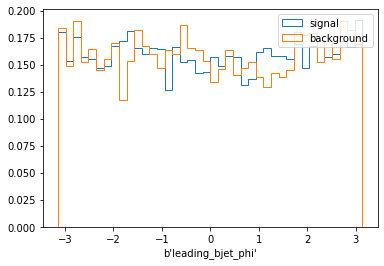

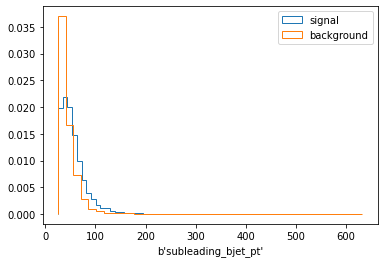

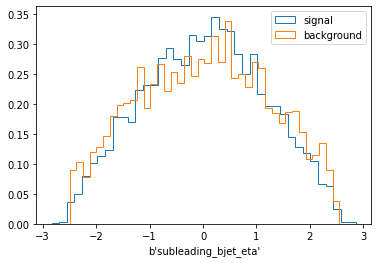

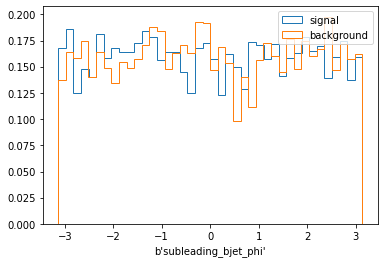

In [24]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label='background')
    plt.xlabel(hlf)
    plt.legend(loc='best')